CDDhallenge Data For Health

---


In [1]:
import os
import io
os.chdir("/home/medo/miniconda/UniBSV/")

In [2]:
# download of the unibsv git
if not os.path.exists("unibsv"):
  !git clone https://gitlab.com/data-challenge-gd4h/unibsv.git
!pip install pdfminer.six
!pip install pymupdf

# Test d'extraction

## Aperçu du pdf

In [3]:
# pdf_path = "/content/unibsv/data/UniBSV/BSV Languedoc-Roussillon/BSV_VITI_LR_N20_09082022.pdf"
# pdf_path = "/content/unibsv/data/UniBSV/BSV Languedoc-Roussillon/BSV_VITI_LR_N11_31052022.pdf"
# pdf_path = "/content/unibsv/data/UniBSV/BSV Languedoc-Roussillon/BSV_VITI_LR_N14_21062022.pdf"
# pdf_path = "/content/unibsv/data/UniBSV/BSV Languedoc-Roussillon/BSV_VITI_LR_N20_09082022.pdf"
pdf_path = "unibsv/data/UniBSV/BSV Languedoc-Roussillon/BSV_VITI_LR_N01_22032022.pdf"
pdf_name = os.path.split(pdf_path)[-1][:-4]

## Extraction des sections avec la taille et la couleur des titres - methode dict

In [4]:
import fitz 

doc = fitz.open(pdf_path)
page = doc.load_page(1)

def clamp_zone_to_page(page, zone_coords):

    page_width, page_height = page.rect[2], page.rect[3]

    clamped_coords = [
        max(0, min(zone_coords[0], page_width - 1)),
        max(0, min(zone_coords[1], page_height - 1)),
        min(zone_coords[2], page_width),
        min(zone_coords[3], page_height),
    ]

    return clamped_coords

def get_block_numbers_in_zone(page, bbox):
    bbox = clamp_zone_to_page(page, bbox)
    print(bbox)
    block_numbers = []
    extracted_text = page.get_text("dict", sort=True, flags=fitz.TEXTFLAGS_TEXT)

    for block in extracted_text["blocks"]:
        if block["type"] == 0:
            block_bbox = block["bbox"]

            if block_bbox[0] >= bbox[0] and block_bbox[1] >= bbox[1] and block_bbox[2] <= bbox[2] and block_bbox[3] <= bbox[3]:
                block_numbers.append(block["number"])

    return block_numbers

In [5]:
def calculate_intersection_area(bbox1, bbox2):
    x1 = max(bbox1[0], bbox2[0])
    y1 = max(bbox1[1], bbox2[1])
    x2 = min(bbox1[2], bbox2[2])
    y2 = min(bbox1[3], bbox2[3])

    if x1 < x2 and y1 < y2:
        return (x2 - x1) * (y2 - y1)
    return 0


def get_block_numbers_in_zone(page, bbox, threshold=0.8):
    block_numbers = []
    extracted_text = page.get_text("dict", sort=True, flags=fitz.TEXTFLAGS_TEXT)

    for block in extracted_text["blocks"]:
        if block["type"] == 0:
            block_bbox = block["bbox"]
            intersection_area = calculate_intersection_area(block_bbox, bbox)

            block_area = (block_bbox[2] - block_bbox[0]) * (block_bbox[3] - block_bbox[1])
            overlap_ratio = intersection_area / block_area

            if overlap_ratio >= threshold:
                block_numbers.append(block["number"])

    return block_numbers
get_block_numbers_in_zone(page,(0, 500, 0, 150))

[]

## Extraction du text par zone

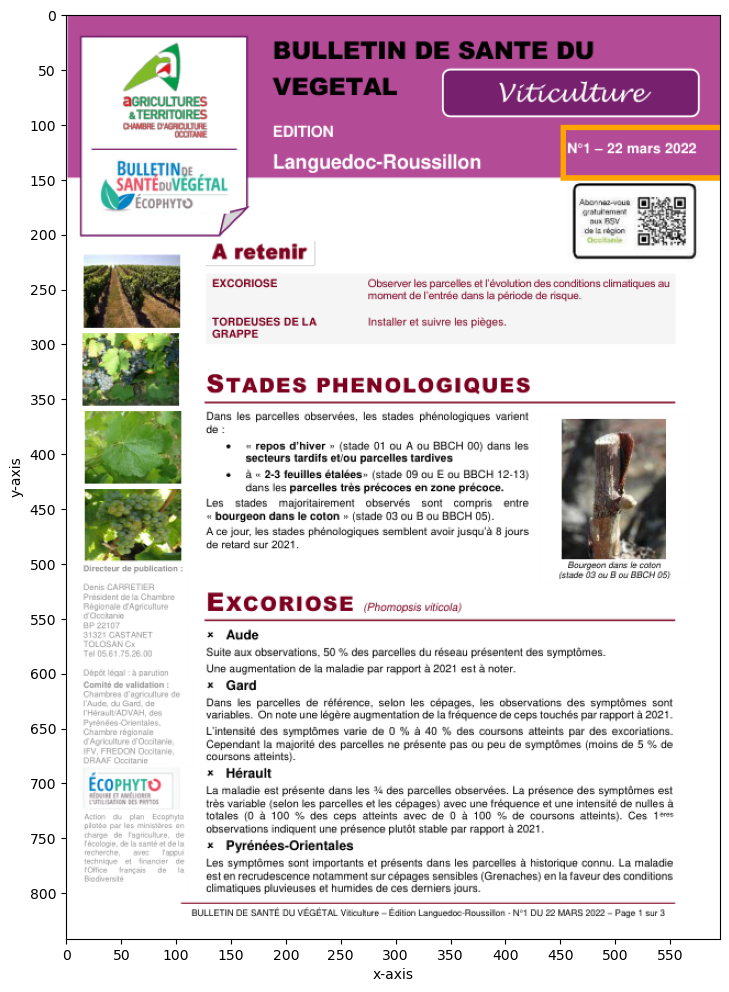

N°1 – 22 mars 2022


In [6]:
import os
from PIL import Image, ImageDraw
import fitz
import matplotlib.pyplot as plt

def get_text_in_zone(page, coords, draw_rectangle=False):
    if draw_rectangle:
        x1, y1, x2, y2 = coords
        pix = page.get_pixmap()
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        draw = ImageDraw.Draw(img)

        draw.rectangle((x1, y1, x2, y2), outline="orange", width=5)

        plt.figure(figsize=(12, 12))
        plt.imshow(img)
        plt.xlabel('x-axis')
        plt.ylabel('y-axis')
        plt.xticks(range(0, pix.width, 50))
        plt.yticks(range(0, pix.height, 50))
        # plt.grid(True)
        plt.show()

    text = ""
    extracted_text = page.get_text("dict", sort=True, flags=fitz.TEXTFLAGS_TEXT)
    # Sort the blocks by their y-coordinates
    sorted_blocks = sorted(extracted_text["blocks"], key=lambda x: x["bbox"][1])

    for block in sorted_blocks:
        if block["type"] == 0:
            for line in block["lines"]:
                for span in line["spans"]:
                    span_bbox = span["bbox"]

                    if span_bbox[0] >= coords[0] and span_bbox[1] >= coords[1] and span_bbox[2] <= coords[2] and span_bbox[3] <= coords[3]:
                      if len(span["text"])>3:
                        text += span["text"] + " "
                      else:
                        text += span["text"]
                text = text.strip()

    return text.strip()

page = doc.load_page(0)
text = get_text_in_zone(page, (450, 100, 600, 150), draw_rectangle=True)
print(text)

In [7]:
import os
from PIL import Image, ImageDraw
import fitz
import numpy as np

def draw_rectangles(page, bbox_coords, color="orange"):
    pix = page.get_pixmap(matrix=fitz.Matrix(2, 2))

    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    draw = ImageDraw.Draw(img)

    # If bbox_coords is a single tuple, convert it to a list of one tuple
    if isinstance(bbox_coords, tuple):
        bbox_coords = [bbox_coords]

    for bbox in bbox_coords:
        scaled_bbox = [coord * 2 for coord in bbox]
        draw.rectangle(scaled_bbox, outline=color, width=5)

    return img
    
def merge_neighbor_bboxes(bbox_coords, threshold=50):
    def overlap_y(bbox1, bbox2):
        y1_1, y2_1 = bbox1[1], bbox1[3]
        y1_2, y2_2 = bbox2[1], bbox2[3]
        return (abs(y1_1 - y1_2) < threshold or abs(y1_1 - y2_2) < threshold) or \
               (abs(y2_1 - y1_2) < threshold or abs(y2_1 - y2_2) < threshold)

    def merge_bbox(bbox1, bbox2):
        return [min(bbox1[0], bbox2[0]), min(bbox1[1], bbox2[1]),
                max(bbox1[2], bbox2[2]), max(bbox1[3], bbox2[3])]

    merged = True
    while merged:
        merged = False
        new_bbox_coords = []
        merged_indices = []

        for i, bbox1 in enumerate(bbox_coords):
            if i in merged_indices:
                continue

            new_bbox = bbox1
            for j, bbox2 in enumerate(bbox_coords):
                if j in merged_indices or i == j:
                    continue

                if overlap_y(new_bbox, bbox2):
                    new_bbox = merge_bbox(new_bbox, bbox2)
                    merged = True
                    merged_indices.append(j)

            new_bbox_coords.append(new_bbox)

        bbox_coords = new_bbox_coords

    return bbox_coords

def process_sections(page, threshold = 50):
    saved_bbox = []
    bbox_coords = []
    identified_sections = []
    identified_sections_coords = []

    page_blocks = page.get_text("dict", sort=True, flags=fitz.TEXTFLAGS_TEXT)

    for block in page_blocks["blocks"]:
        if block["type"] == 0:
            for line in block["lines"]:
                for span in line["spans"]:
                    if span["size"] > 15 and span["color"] == 8192032:
                        saved_bbox.append(span["bbox"])
                        
    for s_bbox in saved_bbox:
        bbox_coords.append([coord for coord in s_bbox])

    bbox_coords = merge_neighbor_bboxes(bbox_coords, threshold)
    for bbox in bbox_coords:
      foo = [coord for coord in bbox]
      found_text = get_text_in_zone(page, foo, draw_rectangle=False)
      if len(found_text) > 2:
        identified_sections.append(found_text)
        identified_sections_coords.append(foo)
    return bbox_coords, identified_sections, identified_sections_coords

def process_document(pdf_path, output_dir="output_dict", draw_in_between_zones=False, display_image=False):
    pdf_name = os.path.splitext(os.path.basename(pdf_path))[0]
    os.makedirs(os.path.join(output_dir, pdf_name), exist_ok=True)
    image_path = os.path.join(output_dir, pdf_name)

    doc = fitz.open(pdf_path)
    
    identified_sections = []
    identified_sections_coords = []

    for page_num, page_i in enumerate(doc):
        pix = page_i.get_pixmap()
        bbox_coords, sections, coords = process_sections(page_i)

        identified_sections.extend(sections)
        identified_sections_coords.extend(coords)

        if len(bbox_coords) > 0:
            img = draw_rectangles(page_i, bbox_coords, color="RED")

            in_between_zones = []

            for i in range(len(coords)):
                zone_start = coords[i][3]  # y2 of the current section
                if i < len(coords) - 1:
                    zone_end = coords[i + 1][1]  # y1 of the next section
                else:
                    zone_end = pix.height/2  # bottom of the current page
                in_between_zones.append((coords[i][0]-10, zone_start + 5, pix.width/2, zone_end - 5))

            if page_num == len(doc) - 1:
                zone_start = coords[-1][3]  # y2 of the last section
                zone_end = pix.height/2  # bottom of the last page
                in_between_zones.append((0, zone_start + 5, pix.width/2, zone_end))

            if draw_in_between_zones:
                img = draw_rectangles(pix, in_between_zones, color="green")

            #image_name = f"page{page_num + 1}.png"
            #image_path_name = os.path.join(image_path, image_name)
            #img.save(image_path_name)
            if display_image:
                display(img)

            # for zone in in_between_zones:
              # text = get_text_in_zone(page, zone, draw_rectangle=False)
              # print(f"\n{text}\n")

    # Calculate in-between zones for the entire document
    # in_between_zones = []

    return identified_sections, identified_sections_coords, in_between_zones


# Processing : 
identified_sections, identified_sections_coords, in_between_zones = process_document(pdf_path, draw_in_between_zones=False)


In [8]:
print("Identified sections:")
for section in identified_sections:
    print(f"- {section}")

print("\nIdentified sections coordinates:")
for coord in identified_sections_coords:
    print(coord)

# print("\nIn-between zones:")
# for zone in in_between_zones:
#     print(zone)


Identified sections:
- STADES PHENOLOGIQUES
- EXCORIOSE  (Phomopsis viticola)
- TORDEUSES DE LA GRAPPE
- ACCIDENTS CLIMATIQUES
- RAVAGEURS SECONDAIRES

Identified sections coordinates:
[127.58000183105469, 318.97247314453125, 431.833740234375, 351.4624938964844]
[127.58000183105469, 517.3524780273438, 367.39373779296875, 549.8424682617188]
[127.58000183105469, 433.09246826171875, 439.43548583984375, 465.5824890136719]
[127.58000183105469, 68.12248229980469, 434.353759765625, 100.61248016357422]
[127.58000183105469, 396.0124816894531, 448.6337585449219, 428.50250244140625]


## Identification des sections de tous les PDF d'un repertoire

In [9]:
import os
import glob
# Set the path of the folder containing PDF files
#folder_path = "/content/unibsv/data/UniBSV/BSV Languedoc-Roussillon"
folder_path = "unibsv/data/UniBSV/BSV Languedoc-Roussillon"

global_sections_list = []

# Use the glob module to find all PDF files in the folder
pdf_files = glob.glob(os.path.join(folder_path, "*.pdf"))

# Loop through each PDF file
for pdf_file in pdf_files:
    # Do something with the PDF file
    print(f"*** Document : {pdf_file} ***\n")
    identified_sections, identified_sections_coords, in_between_zones = process_document(pdf_file, draw_in_between_zones=False)

    global_sections_list.extend(identified_sections)
    
    print("Identified sections:")
    for section in identified_sections:
        print(f"- {section}")
    print("\n")

*** Document : unibsv/data/UniBSV/BSV Languedoc-Roussillon/BSV_VITI_LR_N17_19072022.pdf ***

Identified sections:
- PLUVIOMETRIE
- STADES PHENOLOGIQUES
- FLAVESCENCE DOREE
- OÏDIUM  (Erysiphe necator)
- TORDEUSES DE LA GRAPPE
- MILDIOU  (Plasmopara viticola)
- POURRITURE GRISE  (Botrytis cinerea)
- ASPERGILLUS CARBONARIUS
- BLACK ROT  (Guignardia bidwellii)
- MALADIE DU BOIS
- CICADELLE VERTE
- ACCIDENTS CLIMATIQUES


*** Document : unibsv/data/UniBSV/BSV Languedoc-Roussillon/BSV_VITI_LR_N16_05072022.pdf ***

Identified sections:
- PLUVIOMETRIE
- STADES PHENOLOGIQUES
- FLAVESCENCE DOREE
- OÏDIUM  (Erysiphe necator)
- TORDEUSES DE LA GRAPPE
- MILDIOU  (Plasmopara viticola)
- POURRITURE GRISE  (Botrytis cinerea)
- BLACK ROT  (Guignardia bidwellii)
- MALADIE DU BOIS
- CICADELLE VERTE
- COCHENILLES
- METCALFA PRUINOSA
- ACCIDENTS CLIMATIQUES


*** Document : unibsv/data/UniBSV/BSV Languedoc-Roussillon/BSV_VITI_LR_N15_28062022.pdf ***

Identified sections:
- PLUVIOMETRIE
- STADES PHENOLOGIQ

In [10]:
# duplicates removal
my_list = sorted(set(global_sections_list))
display(my_list)

['ACARIENS',
 'ACCIDENT CLIMATIQUE',
 'ACCIDENT PHYSIOLOGIQUE',
 'ACCIDENTS CLIMATIQUES',
 'ASPERGILLUS CARBONARIUS',
 'AUTRES OBSERVATIONS',
 'BLACK ROT  (Guignardia bidwellii)',
 'CICADELLE VERTE',
 'CICADELLE VERTE  (Empoasca vitis)',
 'CICADELLEVECTRICEDELAFLAVESCENCE DOREE  (Scaphoideus titanus)',
 'COCCINELLE',
 'COCHENILLES',
 'DONNEES DE LA MODELISATION DANS LESBSV VIGNECARACTERISTIQUES DES MODELES',
 'ERINOSE',
 'EUTYPIOSE',
 'EXCORIOSE  (Phomopsis viticola)',
 'FLAVESCENCE DOREE',
 'FOCUS XYLELLA FASTIDIOSA',
 'MALADIE DU BOIS',
 'MALADIES DU BOIS',
 'METCALFA PRUINOSA',
 'MILDIOU  (Plasmopara viticola)',
 'NECROSE BACTERIENNE  (Xylophilus ampelinus)',
 'OÏDIUM  (Erysiphe necator)',
 'PLUVIOMETRIE',
 'POURRITURE ACIDE',
 'POURRITURE GRISE',
 'POURRITURE GRISE  (Botrytis cinerea)',
 'RAVAGEURS SECONDAIRES',
 'RAVAGEURSSECONDAIRES',
 'STADES PHENOLOGIQUES',
 'Stade « baies à taille de grains de plomb »(stade 29 ou BBCH 73)CICADELLEVECTRICEDELAFLAVESCENCE DOREE  (Scaphoideus tit

## Extraction des contenus des sections grâce aux numéros de blocs intermédiaires

In [11]:
doc = fitz.open(pdf_path)

In [12]:
identified_sections, identified_sections_coords, in_between_zones = process_document(pdf_path, draw_in_between_zones=False)

In [67]:
def calculate_in_between_zones(page, section_A, section_B=None):

    if section_B == None:
        # Zone on last page from section_A to the bottom of the page
        return [(section_A[0], section_A[3], page.rect.width, page.rect.height - 40)]
    # If section_B is above section_A, it means we have moved to a new page
    if section_B[1] < section_A[3]:
        # Zone on page 1 from section_A to the bottom of the page
        zone1 = (section_A[0], section_A[3], page.rect.width, page.rect.height - 40)
        # Zone on page 2 from the top of the page to section_B
        zone2 = (section_B[0], 0, page.rect.width, section_B[1])
        
        return [zone1, zone2]
    else:
        # If we are on the same page, calculate the zone as before
        x1 = min(section_A[0], section_B[0])
        x2 = page.rect.width
        y1 = section_A[3]
        y2 = section_B[1]

        return [(x1, y1, x2, y2)]

In [68]:
identified_sections_coords

[[127.58000183105469, 318.97247314453125, 431.833740234375, 351.4624938964844],
 [127.58000183105469,
  517.3524780273438,
  367.39373779296875,
  549.8424682617188],
 [127.58000183105469,
  433.09246826171875,
  439.43548583984375,
  465.5824890136719],
 [127.58000183105469, 68.12248229980469, 434.353759765625, 100.61248016357422],
 [127.58000183105469,
  396.0124816894531,
  448.6337585449219,
  428.50250244140625]]

In [69]:
len(identified_sections_coords)

5

In [79]:
output = []
temp = []
j = 0
for i in range(len(identified_sections_coords)):
    #print(i)
    if i == (len(identified_sections_coords)-1):
        zones = calculate_in_between_zones(doc.load_page(j), identified_sections_coords[i])
    else:
        zones = calculate_in_between_zones(doc.load_page(j), identified_sections_coords[i], identified_sections_coords[i+1])
    
    temp.append(zones[0])
    #output.append(temp)
    if len(zones) > 1:
        output.append(temp)
        j += 1
        temp = []
        for e in range(1, len(zones)-1):
            temp.append(zones[e])
    print(j)

0
1
2
2
2


In [80]:
len(output)

7

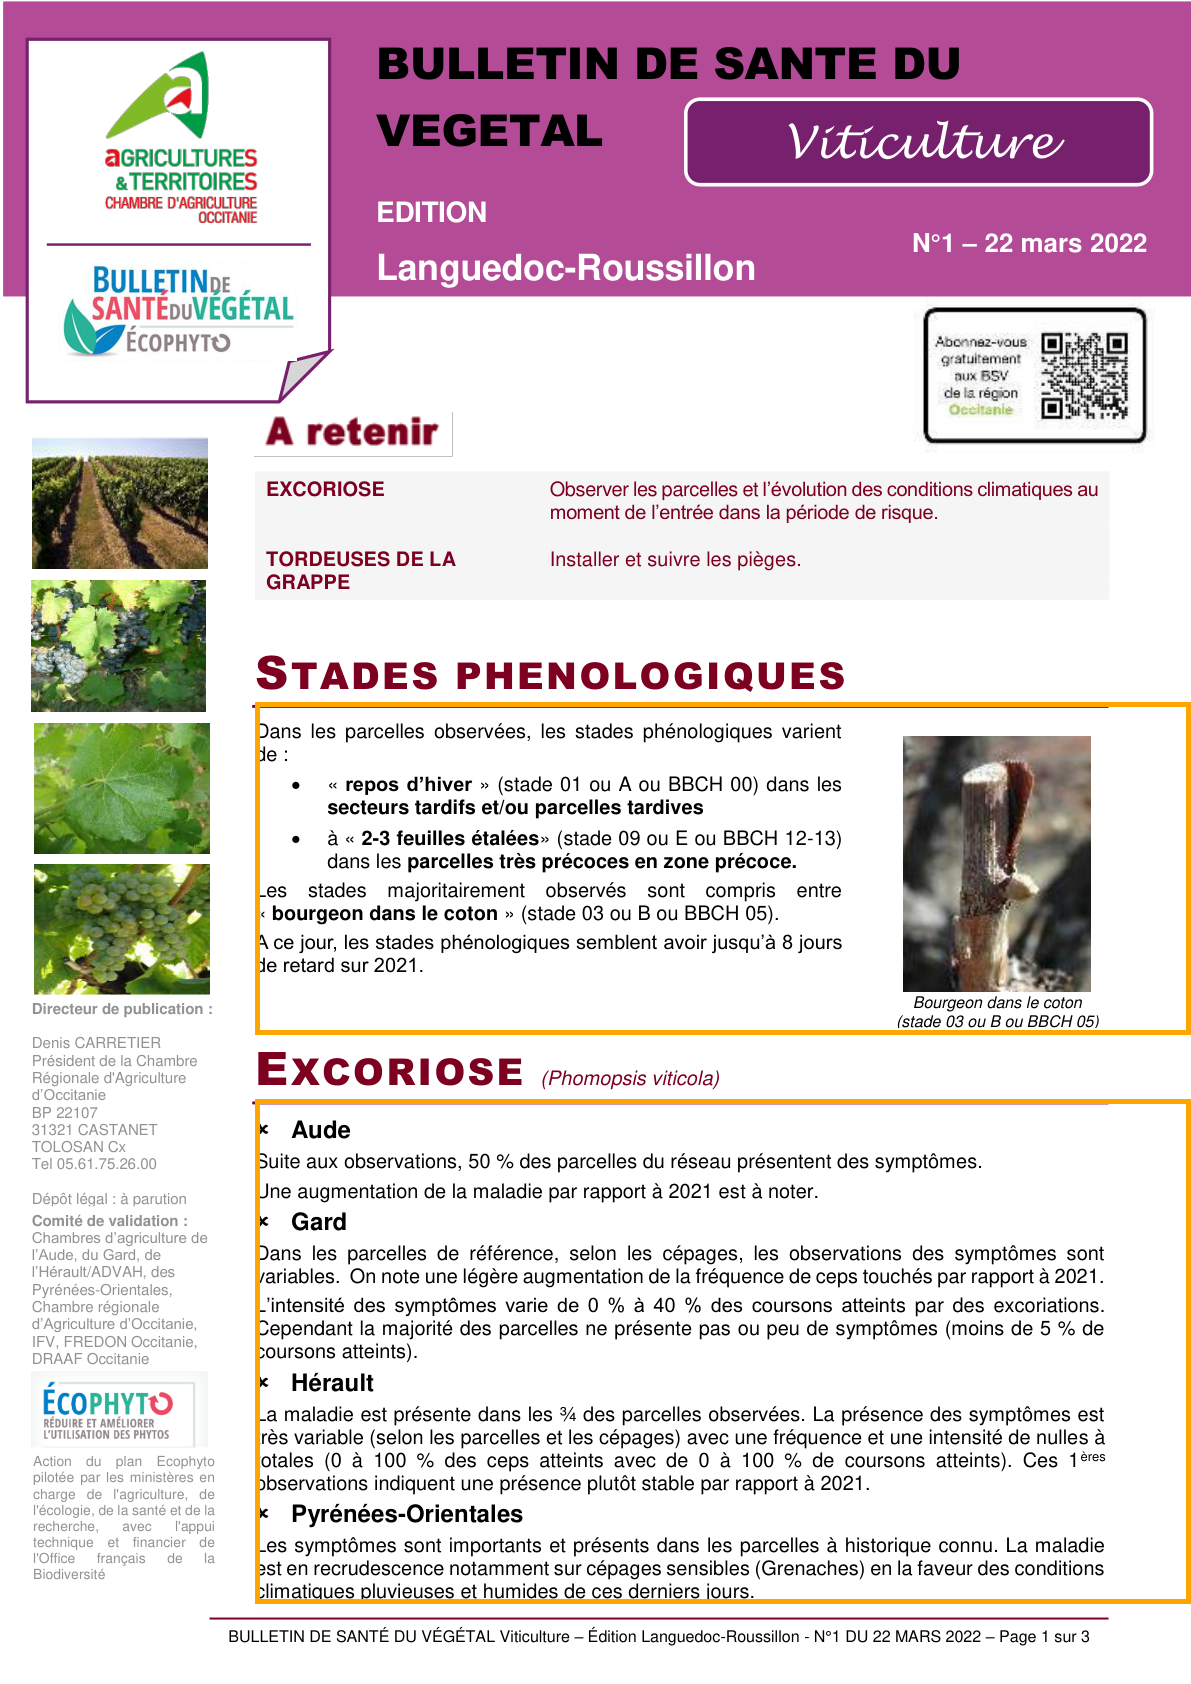

Dans les parcelles observées, les stades phénologiques varientde :« repos d’hiver  » (stade 01 ou A ou BBCH 00) dans lessecteurs tardifs et/ou parcelles tardivesà «  2-3 feuilles étalées » (stade 09 ou E ou BBCH 12-13)dans les  parcelles très précoces en zone précoce.Les stades majoritairement observés sont compris entre« bourgeon dans le coton  » (stade 03 ou B ou BBCH 05).A ce jour, les stades phénologiques semblent avoir jusqu’à 8 jours de retard sur 2021.Bourgeon dans le coton(stade 03 ou B ou BBCH 05)
¬
 AudeSuite aux observations, 50 % des parcelles du réseau présentent des symptômes.Une augmentation de la maladie par rapport à 2021 est à noter. GardDans les parcelles de référence, selon les cépages, les observations des symptômes sontvariables.  On note une légère augmentation de la fréquence de ceps touchés par rapport à 2021.L’intensité des symptômes varie de 0 % à 40 % des coursons atteints par des excoriations.Cependant la majorité des parcelles ne présente pas ou peu de

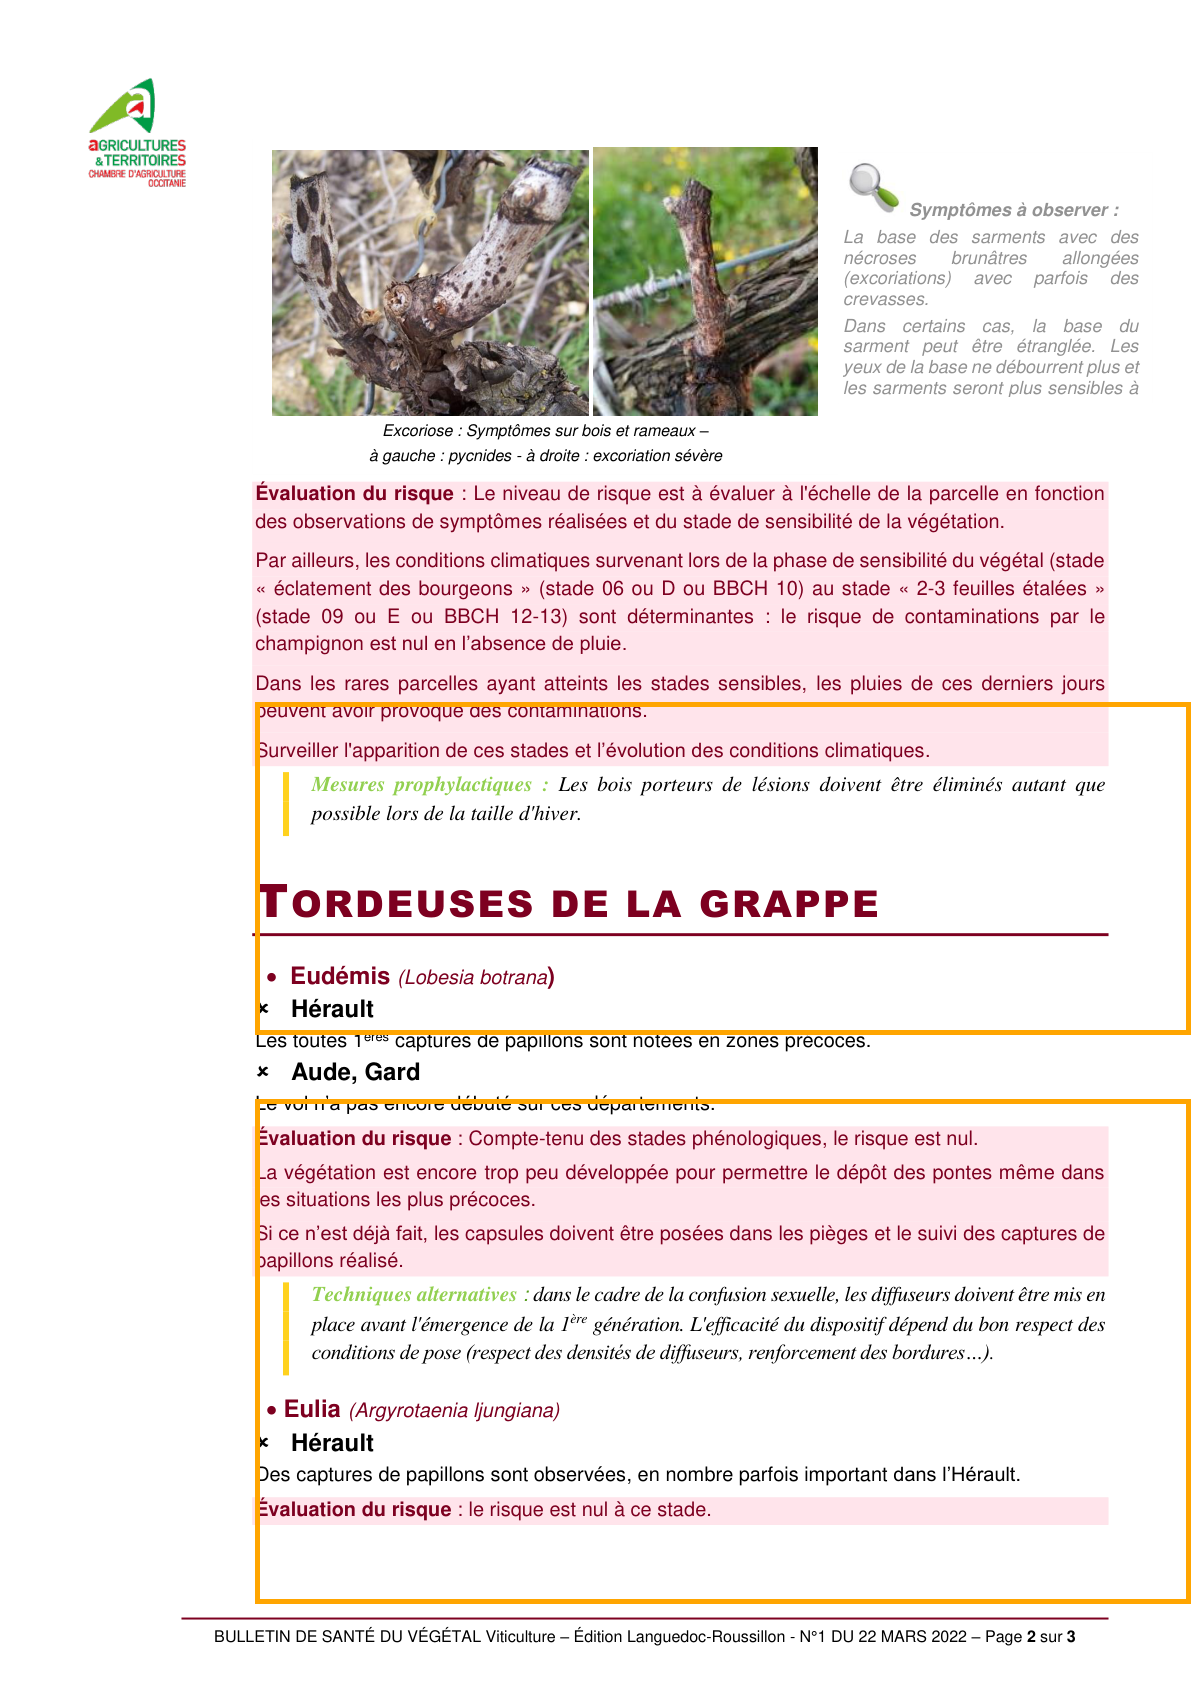

Surveiller l'apparition de ces stades et l’évolution des conditions climatiques.Mesures prophylactiques :  Les bois porteurs de lésions doivent être éliminés autant quepossible lors de la taille d'hiver.TORDEUSES DE LA GRAPPE  Eudémis  (Lobesia botrana ) Hérault
¬
Évaluation du risque  : Compte-tenu des stades phénologiques, le risque est nul.La végétation est encore trop peu développée pour permettre le dépôt des pontes même dansles situations les plus précoces.Si ce n’est déjà fait, les capsules doivent être posées dans les pièges et le suivi des captures depapillons réalisé.Techniques alternatives  : dans le cadre de la confusion sexuelle, les diffuseurs doivent être mis enplace avant l'émergence de la 1 ère génération. L'efficacité du dispositif dépend du bon respect desconditions de pose (respect des densités de diffuseurs, renforcement des bordures…). Eulia  (Argyrotaenia ljungiana) HéraultDes captures de papillons sont observées, en nombre parfois important dans l’Hérault.Év

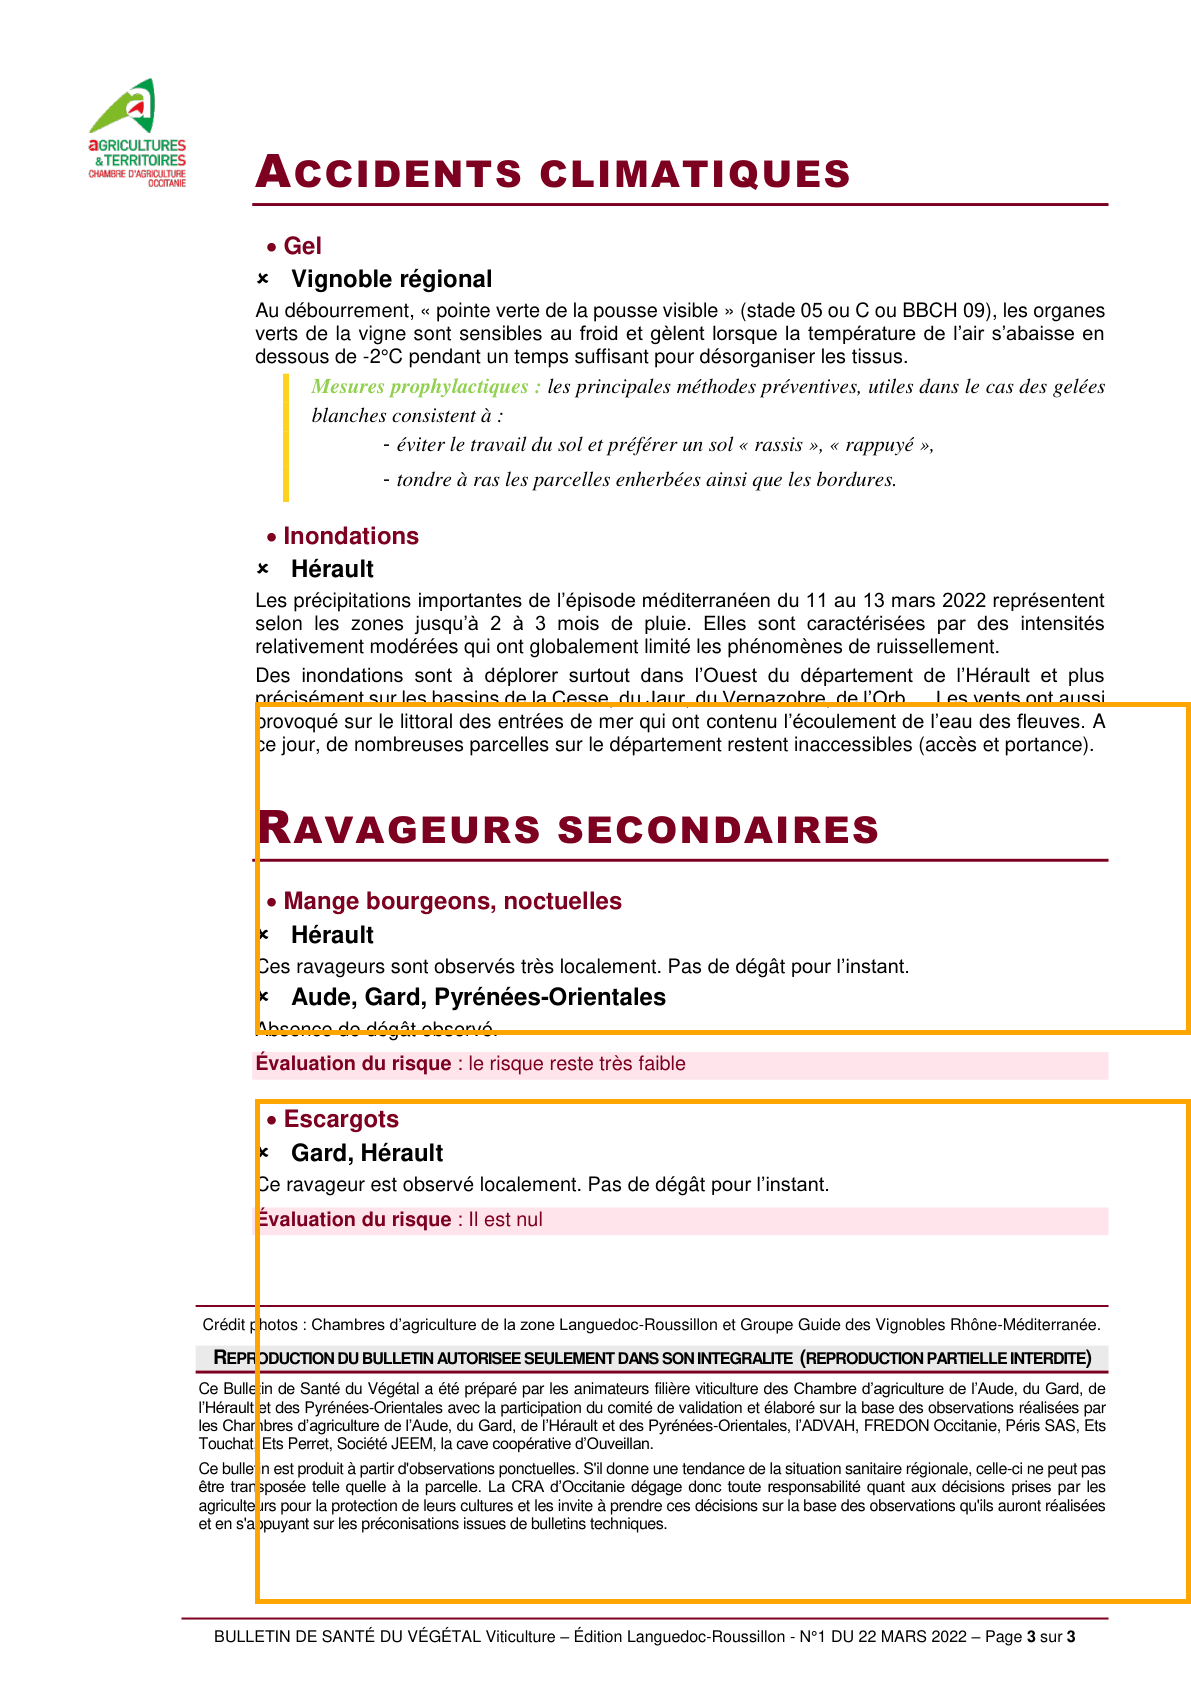

provoqué sur le littoral des entrées de mer qui ont contenu l’écoulement de l’eau des fleuves. Ace jour, de nombreuses parcelles sur le département restent inaccessibles (accès et portance).RAVAGEURS SECONDAIRES Mange bourgeons, noctuelles HéraultCes ravageurs sont observés très localement. Pas de dégât pour l’instant. Aude, Gard, Pyrénées-Orientales
¬
 Escargots Gard, HéraultCe ravageur est observé localement. Pas de dégât pour l’instant.Évaluation du risque  : Il est nul(REPRODUCTION PARTIELLE INTERDITE )
¬


ValueError: page not in document

In [81]:
for a, elt in enumerate(output):
    #print(f"__________PAGE{a}__________")
    page = doc.load_page(a)
    img = draw_rectangles(page, elt, color="orange")

    display(img)
    
    for zone in elt:
        print(get_text_in_zone(page, zone, draw_rectangle=False))
        print("¬")

## Sandbox

In [ ]:
import logging
import os
import random

from fitz import fitz, Pixmap

from unibsv.preprocess import detect_tables

def visualize_blocks(file_path: str, output_dir: str) -> list[str]:
    """
    Render PDF pages as images with highlighted blocks, lines and drawings, to provide a way to understand page layouts.
    :param file_path: PDF source file
    :param output_dir: where images should be written
    :return: the paths of the generated images
    """
    images = []

    with fitz.open(file_path) as doc:
        for page in doc:  # iterate through the pages
            pix: Pixmap = page.get_pixmap()  # render page to an image

            # drawings
            page_drawings = page.get_drawings()
            for i in range(len(page_drawings)):
                #color = (random.randint(100, 250), random.randint(100, 250), random.randint(100, 250))
                color = (255,0,0)
                bbox = page_drawings[i]["rect"]
                draw_bbox(pix, bbox, color, fill=True)

            # blocks & lines
            page_blocks = page.get_text("dict", sort=True)["blocks"]
            for i in range(len(page_blocks)):
                block = page_blocks[i]
                #color = (100 + int(i * 155 / len(page_blocks)), 50, 50)
                color = (0,255,0)
                draw_bbox(pix, block["bbox"], color)
                if "lines" in block:
                    for line_idx, line in enumerate(block["lines"]):
                        draw_bbox(pix, line["bbox"], (50, 50, 100 + int(i * 155 / len(page_blocks))), 2)

            # resolved tables
            tables = detect_tables(page)
            logging.debug(f"resolved {len(tables)} table(s) for page {page.number}")
            for i in range(len(tables)):
                #color = (50, 50, 100 + int(i * 155 / len(tables)))
                color = (0,0,255)
                for line in tables[i]:
                    for cell in line:
                        draw_bbox(pix, cell, color, 7)

            output_image = os.path.join(output_dir, f"{os.path.basename(doc.name)}-{page.number}.png")
            pix.save(output_image)  # store image as a PNG
            images.append(output_image)
    return images


def draw_bbox(pix, bbox, color, dashed: int = 0, fill: bool = False):
    """
    Draw a bounding box of the given color.
    :param pix: the Pixmap to draw to
    :param bbox: the bounding box to draw
    :param color: the color to use
    :param dashed: the length of dashes, if any
    :param fill: if an inner margin of the box should be colored
    """
    # clip the given box to the pixmap dimensions
    x0 = max(0, int(min(bbox[0], bbox[2])))
    y0 = max(0, int(min(bbox[1], bbox[3])))
    x1 = min(pix.width - 1, int(max(bbox[0], bbox[2])))
    y1 = min(pix.height - 1, int(max(bbox[1], bbox[3])))
    i = 0
    # draw horizontal lines
    for x in range(x0, x1):
        if dashed > 0:
            i += 1
            if int(i / dashed) % 2 == 1:
                continue
        pix.set_pixel(x, y0, color)
        pix.set_pixel(x, y1, color)
    # draw vertical lines
    for y in range(y0, y1):
        if dashed > 0:
            i += 1
            if int(i / dashed) % 2 == 1:
                continue
        pix.set_pixel(x0, y, color)
        pix.set_pixel(x1, y, color)

    # fill an inner margin of 1 to 4 pixels wide
    if fill and x1 - x0 > 2 and y1 - y0 > 2:
        for i in range(1, min(4, int((x1 - x0) / 2))):
            for j in range(1, min(4, int((y1 - y0) / 2))):
                draw_bbox(pix, (x0 + i, y0 + j, x1 - i, y1 - j), color, dashed, fill=False)

visualize_blocks(pdf_path, "/home/medo/miniconda/UniBSV/testoo")

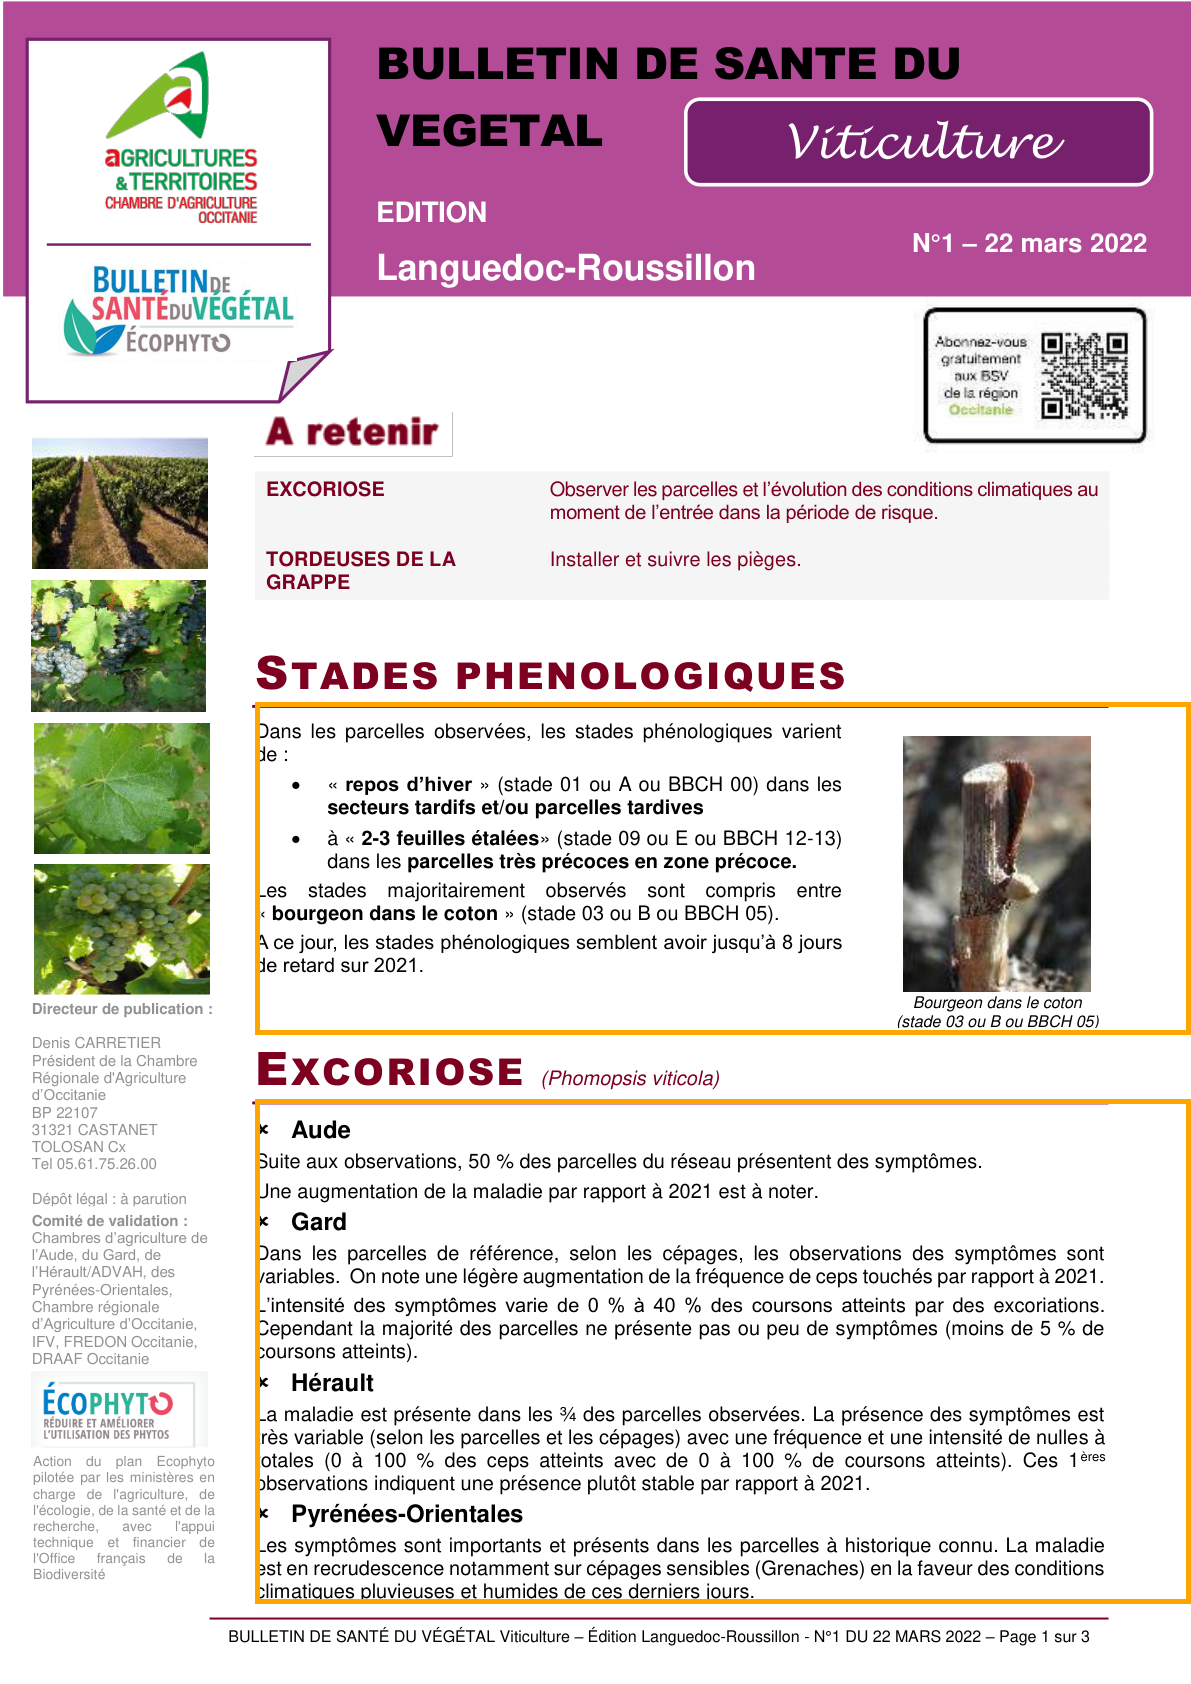

Dans les parcelles observées, les stades phénologiques varientde :« repos d’hiver  » (stade 01 ou A ou BBCH 00) dans lessecteurs tardifs et/ou parcelles tardivesà «  2-3 feuilles étalées » (stade 09 ou E ou BBCH 12-13)dans les  parcelles très précoces en zone précoce.Les stades majoritairement observés sont compris entre« bourgeon dans le coton  » (stade 03 ou B ou BBCH 05).A ce jour, les stades phénologiques semblent avoir jusqu’à 8 jours de retard sur 2021.Bourgeon dans le coton(stade 03 ou B ou BBCH 05)
¬
 AudeSuite aux observations, 50 % des parcelles du réseau présentent des symptômes.Une augmentation de la maladie par rapport à 2021 est à noter. GardDans les parcelles de référence, selon les cépages, les observations des symptômes sontvariables.  On note une légère augmentation de la fréquence de ceps touchés par rapport à 2021.L’intensité des symptômes varie de 0 % à 40 % des coursons atteints par des excoriations.Cependant la majorité des parcelles ne présente pas ou peu de

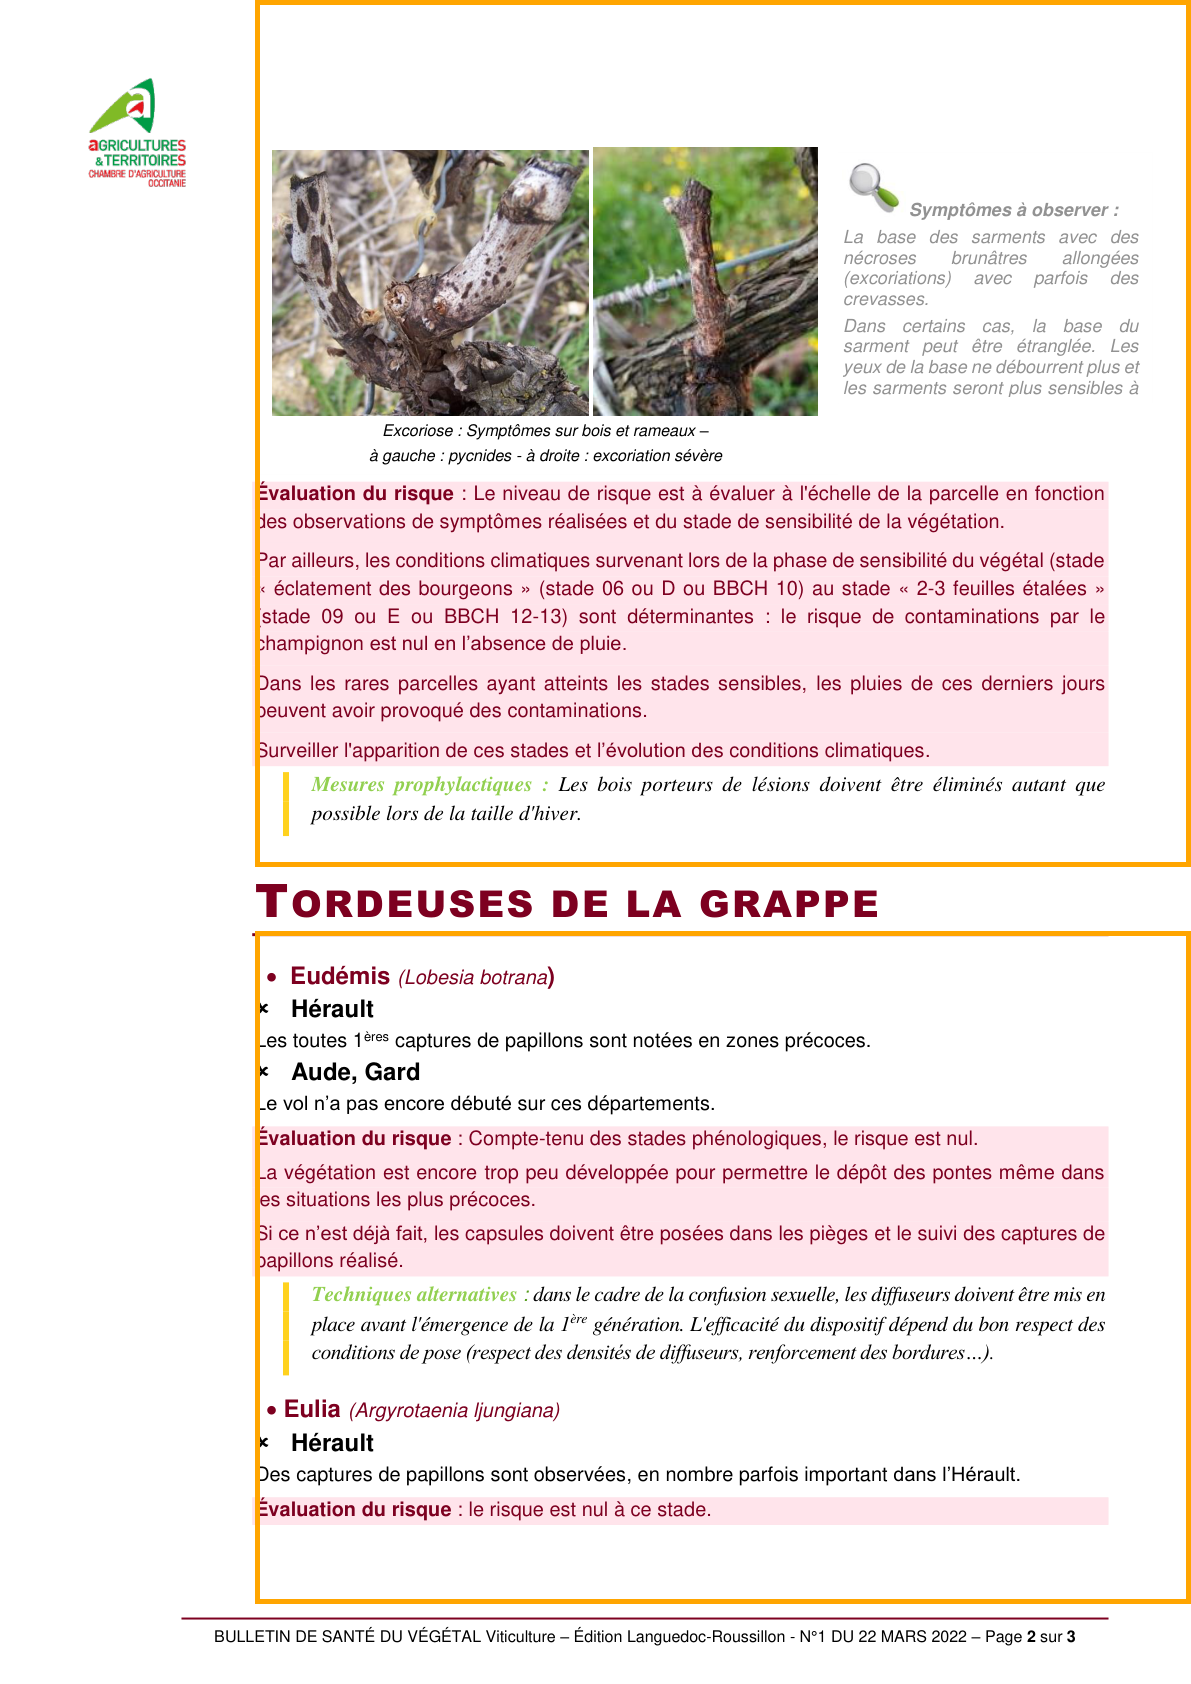

Symptômes à observer :La base des sarments avec desnécrosesbrunâtresallongées(excoriations)avecparfoisdescrevasses.Dans certains cas, la base dusarment peut être étranglée. Lesyeux de la base ne débourrent plus etles sarments seront plus sensibles àla casse par le vent.Excoriose : Symptômes sur bois et rameaux –à gauche : pycnides - à droite : excoriation sévèreÉvaluation du risque  : Le niveau de risque est à évaluer à l'échelle de la parcelle en fonctiondes observations de symptômes réalisées et du stade de sensibilité de la végétation.Par ailleurs, les conditions climatiques survenant lors de la phase de sensibilité du végétal (stade« éclatement des bourgeons » (stade 06 ou D ou BBCH 10) au stade « 2-3 feuilles étalées »(stade 09 ou E ou BBCH 12-13) sont déterminantes : le risque de contaminations par lechampignon est nul en l’absence de pluie.Dans les rares parcelles ayant atteints les stades sensibles, les pluies de ces derniers jourspeuvent avoir provoqué des contaminations.Surve

In [44]:
output = []
temp = []
for i in range(len(identified_sections_coords)-1):
    zones = calculate_in_between_zones(page, identified_sections_coords[i], identified_sections_coords[i+1])
    if len(zones) == 1:
        temp.append(zones[0])
    else:
        temp.append(zones[0])
        output.append(temp)
        temp = []
        for j in range(1, len(zones)):
            temp.append(zones[j])

for a, elt in enumerate(output):
    #print(f"__________PAGE{a}__________")
    page = doc.load_page(a)
    img = draw_rectangles(page, elt, color="orange")

    display(img)
    
    for zone in elt:
        print(get_text_in_zone(page, zone, draw_rectangle=False))
        print("¬")

## Sandbox

In [ ]:
import logging
import os
import random

from fitz import fitz, Pixmap

from unibsv.preprocess import detect_tables

def visualize_blocks(file_path: str, output_dir: str) -> list[str]:
    """
    Render PDF pages as images with highlighted blocks, lines and drawings, to provide a way to understand page layouts.
    :param file_path: PDF source file
    :param output_dir: where images should be written
    :return: the paths of the generated images
    """
    images = []

    with fitz.open(file_path) as doc:
        for page in doc:  # iterate through the pages
            pix: Pixmap = page.get_pixmap()  # render page to an image

            # drawings
            page_drawings = page.get_drawings()
            for i in range(len(page_drawings)):
                #color = (random.randint(100, 250), random.randint(100, 250), random.randint(100, 250))
                color = (255,0,0)
                bbox = page_drawings[i]["rect"]
                draw_bbox(pix, bbox, color, fill=True)

            # blocks & lines
            page_blocks = page.get_text("dict", sort=True)["blocks"]
            for i in range(len(page_blocks)):
                block = page_blocks[i]
                #color = (100 + int(i * 155 / len(page_blocks)), 50, 50)
                color = (0,255,0)
                draw_bbox(pix, block["bbox"], color)
                if "lines" in block:
                    for line_idx, line in enumerate(block["lines"]):
                        draw_bbox(pix, line["bbox"], (50, 50, 100 + int(i * 155 / len(page_blocks))), 2)

            # resolved tables
            tables = detect_tables(page)
            logging.debug(f"resolved {len(tables)} table(s) for page {page.number}")
            for i in range(len(tables)):
                #color = (50, 50, 100 + int(i * 155 / len(tables)))
                color = (0,0,255)
                for line in tables[i]:
                    for cell in line:
                        draw_bbox(pix, cell, color, 7)

            output_image = os.path.join(output_dir, f"{os.path.basename(doc.name)}-{page.number}.png")
            pix.save(output_image)  # store image as a PNG
            images.append(output_image)
    return images


def draw_bbox(pix, bbox, color, dashed: int = 0, fill: bool = False):
    """
    Draw a bounding box of the given color.
    :param pix: the Pixmap to draw to
    :param bbox: the bounding box to draw
    :param color: the color to use
    :param dashed: the length of dashes, if any
    :param fill: if an inner margin of the box should be colored
    """
    # clip the given box to the pixmap dimensions
    x0 = max(0, int(min(bbox[0], bbox[2])))
    y0 = max(0, int(min(bbox[1], bbox[3])))
    x1 = min(pix.width - 1, int(max(bbox[0], bbox[2])))
    y1 = min(pix.height - 1, int(max(bbox[1], bbox[3])))
    i = 0
    # draw horizontal lines
    for x in range(x0, x1):
        if dashed > 0:
            i += 1
            if int(i / dashed) % 2 == 1:
                continue
        pix.set_pixel(x, y0, color)
        pix.set_pixel(x, y1, color)
    # draw vertical lines
    for y in range(y0, y1):
        if dashed > 0:
            i += 1
            if int(i / dashed) % 2 == 1:
                continue
        pix.set_pixel(x0, y, color)
        pix.set_pixel(x1, y, color)

    # fill an inner margin of 1 to 4 pixels wide
    if fill and x1 - x0 > 2 and y1 - y0 > 2:
        for i in range(1, min(4, int((x1 - x0) / 2))):
            for j in range(1, min(4, int((y1 - y0) / 2))):
                draw_bbox(pix, (x0 + i, y0 + j, x1 - i, y1 - j), color, dashed, fill=False)

visualize_blocks(pdf_path, "/home/medo/miniconda/UniBSV/testoo")